In [ ]:
#!pip uninstall huetracer -y
#!pip install huetracer
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import numpy as np
import pandas as pd
import huetracer
import scvi
import gc
import math

%config InlineBackend.print_figure_kwargs={"facecolor": "w"}
%config InlineBackend.figure_format="retina"

scvi.settings.seed = 0
SEED = 42

np.random.seed(SEED)
random.seed(SEED)


In [3]:
### parameters to be input
#SAMPLE_NAME = 'G1'
SAMPLE_NAME = 'FFPE9'
lib_id = SAMPLE_NAME # list(sp_adata.uns['spatial'].keys())[0]

path = os.path.expanduser("~")+"/Desktop/space/GCTB_bin2cell"
save_path_for_today = os.path.expanduser("~")+"/tmp/outputs/250610_" + SAMPLE_NAME
source_image_path = "../VisiumHD/image/microscope_image/" + SAMPLE_NAME + ".tif"
expression_path = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_002um"
### optional 8 um binned dataset
expression_path_8um = "../VisiumHD/spaceranger/" + SAMPLE_NAME + "/outs/binned_outputs/square_008um"
###

# single cell transcriptome dataset (10X Chromium)
sc_adata_SK286_01_dir = '../../Single_cell_RNA_seq/SK286/SK286_01/count/sample_filtered_feature_bc_matrix'
sc_adata_SK286_04_dir = '../../Single_cell_RNA_seq/SK286/SK286_04/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_06_dir = '../../Single_cell_RNA_seq/SK318/GCTB_06/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_07_dir = '../../Single_cell_RNA_seq/SK318/GCTB_07/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_08_dir = '../../Single_cell_RNA_seq/SK318/GCTB_08/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_09_dir = '../../Single_cell_RNA_seq/SK318/GCTB_09/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_11_dir = '../../Single_cell_RNA_seq/SK318/GCTB_11/count/sample_filtered_feature_bc_matrix'
sc_adata_SK318_12_dir = '../../Single_cell_RNA_seq/SK318/GCTB_12/count/sample_filtered_feature_bc_matrix'

# area to be analyzed
# ## GCTB spatial G1, FFPE9
mask_large_x1, mask_large_x2, mask_large_y1, mask_large_y2 = 450, 1950, 250, 1750

# List of target gene names
target_genes = [
    'TNFSF11', 'LIF', 'TNFRSF11A', 'LIFR',
    'CTSK', 'CTSB', 'LMNB1', 'MEGF10',
    'MMP9', 'MMP13', 'SPP1', 'GRN',
    'NOTCH3', 'SDC2', 'TIMP1', 'SPARC',
    'ACP5'
    # Add more genes here if needed
]


# setting for filenames
label_image_filename = "he_labels_image.pdf"
h5ad_filename = SAMPLE_NAME + "_b2c.h5ad"
h5ad_full_filename = SAMPLE_NAME + "_2um.h5ad"
h5ad_predicted_full_filename = SAMPLE_NAME + "_nucleus_predicted.h5ad"
h5ad_sc_filtered_full_filename = SAMPLE_NAME + "_single_cell_filtered.h5ad"
h5ad_sc_microenvironment_full_filename = SAMPLE_NAME + "_single_cell_microenvironment.h5ad"
save_spatial_plot_path = os.path.join(save_path_for_today, "cropped_spatial_plot.svg")
save_svg_path = os.path.join(save_path_for_today, "spatial_salvage_labels.svg")
h5ad_save_path = os.path.join(save_path_for_today, h5ad_filename)
h5ad_full_save_path = os.path.join(save_path_for_today, h5ad_full_filename)
h5ad_predicted_full_save_path = os.path.join(save_path_for_today, h5ad_predicted_full_filename)
h5ad_sc_filtered_full_save_path = os.path.join(save_path_for_today, h5ad_sc_filtered_full_filename)
h5ad_microenvironment_full_save_path = os.path.join(save_path_for_today, h5ad_sc_microenvironment_full_filename)

os.chdir(path)
os.makedirs(save_path_for_today, exist_ok=True)


# Single cell transcriptome annotation

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK286_01_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=100)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 1000)
sc.pp.filter_cells(sc_adata, max_counts = 80000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata1 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK286_04_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=500)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 500)
sc.pp.filter_cells(sc_adata, max_counts = 15000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata2 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_06_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=500)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 500)
sc.pp.filter_cells(sc_adata, max_counts = 10000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata3 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_07_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=200)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 200)
sc.pp.filter_cells(sc_adata, max_counts = 1500)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata4 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_08_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=800)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 1000)
sc.pp.filter_cells(sc_adata, max_counts = 10000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata5 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_09_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=500)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 1000)
sc.pp.filter_cells(sc_adata, max_counts = 40000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata6 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_11_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=500)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 1000)
sc.pp.filter_cells(sc_adata, max_counts = 10000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata7 = sc_adata.copy()

In [ ]:
sc_adata = sc.read_10x_mtx(
    sc_adata_SK318_12_dir,  # 入力ディレクトリ
    var_names='gene_symbols', cache=True)
sc_adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc_adata.var['MT'] = sc_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(sc_adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)
sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 10], kde=False)
plt.show()

print('Total number of cells: {:d}'.format(sc_adata.n_obs))

# Filtering
sc.pp.filter_cells(sc_adata, min_genes=300)
sc.pp.filter_genes(sc_adata, min_cells=30)
print('Number of cells after low-quality cell filter: {:d}'.format(sc_adata.n_obs))

sc.pp.filter_cells(sc_adata, min_counts = 500)
sc.pp.filter_cells(sc_adata, max_counts = 3000)
print('Number of cells after count filter: {:d}'.format(sc_adata.n_obs))

sc_adata = sc_adata[sc_adata.obs['pct_counts_MT'] < 2]
print('Number of cells after MT filter: {:d}'.format(sc_adata.n_obs))

sc.pl.highest_expr_genes(sc_adata, n_top=30)
sc.pl.violin(sc_adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'], jitter=0.4, multi_panel=True)
sc.pl.scatter(sc_adata, 'total_counts', 'n_genes_by_counts', color='pct_counts_MT', size=40)
sc.pl.scatter(sc_adata, x='total_counts', y='pct_counts_MT')
fig = plt.figure()
sns.displot(sc_adata.obs['pct_counts_MT'][sc_adata.obs['pct_counts_MT'] < 3], kde=False)
plt.show()

sc_adata8 = sc_adata.copy()

In [12]:
# sc_adata4 is a poor quality sample

# common_genes = set(sc_adata1.var_names) & set(sc_adata2.var_names) & set(sc_adata3.var_names) & set(sc_adata4.var_names) & set(sc_adata5.var_names) & set(sc_adata6.var_names) & set(sc_adata7.var_names) & set(sc_adata8.var_names)
common_genes = set(sc_adata1.var_names) & set(sc_adata2.var_names) & set(sc_adata3.var_names) & set(sc_adata5.var_names) & set(sc_adata6.var_names) & set(sc_adata7.var_names) & set(sc_adata8.var_names)
sc_adata1 = sc_adata1[:, list(common_genes)]
sc_adata2 = sc_adata2[:, list(common_genes)]
sc_adata3 = sc_adata3[:, list(common_genes)]
# sc_adata4 = sc_adata4[:, list(common_genes)]
sc_adata5 = sc_adata5[:, list(common_genes)]
sc_adata6 = sc_adata6[:, list(common_genes)]
sc_adata7 = sc_adata7[:, list(common_genes)]
sc_adata8 = sc_adata8[:, list(common_genes)]
# sc_adatas = [sc_adata1, sc_adata2, sc_adata3, sc_adata4, sc_adata5, sc_adata6, sc_adata7, sc_adata8]
sc_adatas = [sc_adata1, sc_adata2, sc_adata3, sc_adata5, sc_adata6, sc_adata7, sc_adata8]
sc_adata_merged = sc_adatas[0].concatenate(sc_adatas[1:], batch_key='batch')
del sc_adata1, sc_adata2, sc_adata3, sc_adata4, sc_adata5, sc_adata6, sc_adata7, sc_adata8
gc.collect()
# save raw count data
sc_adata_merged.layers["counts"] = sc_adata_merged.X.copy()
sc_adata_merged.raw = sc_adata_merged

/var/folders/4d/y2tgzy191n37wnz840jkr6980000gp/T/ipykernel_19426/3787784722.py:15: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  sc_adata_merged = sc_adatas[0].concatenate(sc_adatas[1:], batch_key='batch')


In [ ]:
# reset with raw count data
# Harmonyのランダム性排除のためkmeansからAgglomerativeClusteringにclustering手法を変更

import importlib
import huetracer  # 対象パッケージ名に合わせて

importlib.reload(huetracer)


np.random.seed(SEED)
random.seed(SEED)
sc_adata_merged.X = sc_adata_merged.raw.X.copy()
sc_adata_merged.var = sc_adata_merged.raw.var.copy()
sc.pp.normalize_total(sc_adata_merged, target_sum=1e4)
sc.pp.log1p(sc_adata_merged)
sc.pp.highly_variable_genes(sc_adata_merged, flavor = 'seurat_v3', n_top_genes=2000,
                            layer = "counts", batch_key="batch", subset = False)
hvg_genes = sc_adata_merged.var_names[sc_adata_merged.var['highly_variable']].tolist()
sc.tl.pca(sc_adata_merged, svd_solver='arpack',use_highly_variable=True, n_comps=30, random_state=SEED)
ho = huetracer.run_harmony(sc_adata_merged.obsm['X_pca'], sc_adata_merged.obs, 'batch',random_state=SEED)
sc_adata_merged.obsm['X_pca_harmony'] = ho.Z_corr.T
sc.pp.neighbors(sc_adata_merged, use_rep='X_pca_harmony', random_state=SEED)
sc.tl.umap(sc_adata_merged, random_state=SEED)
sc.tl.leiden(sc_adata_merged, resolution=1, key_added='leiden', random_state=SEED)
sc_adata_merged.obs['leiden'] = sc_adata_merged.obs['leiden'].apply(lambda x: f"C{x}")
sc.pl.pca(sc_adata_merged, color='total_counts', components=['1,2', '2,3', '1,3'])
sc.pl.pca_variance_ratio(sc_adata_merged, log=True)
sc_adata_merged.var.sort_values("variances_norm",ascending=False).head(10)
sc.pl.umap(sc_adata_merged, color=['leiden', 'total_counts', 'batch'],use_raw=False)
sc.pl.umap(sc_adata_merged, color=['EGFR', 'COL1A1', 'CTSK'],use_raw=False)

In [ ]:
sc.tl.dendrogram(sc_adata_merged, groupby='leiden')
sc.tl.rank_genes_groups(sc_adata_merged, 'leiden', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups(sc_adata_merged, n_genes=25, sharey=False)

genes_df = pd.DataFrame(sc_adata_merged.uns['rank_genes_groups']['names'])
genes = genes_df.head(3).values.tolist()  # top 3 genes
genes = [item for sublist in genes for item in sublist]
genes = list(dict.fromkeys(genes))
genes = [str(g) for g in genes]
for i in range(0, len(genes), 4):
    subset_genes = [str(g) for g in genes[i:i + 4]]
    sc.pl.violin(
        sc_adata_merged,
        subset_genes,
        groupby='leiden',
        use_raw=False
    )

In [ ]:
gene_array = np.array(sc_adata_merged.uns['rank_genes_groups']['names'].tolist())
gene_list = np.unique(gene_array[0:4,:].flatten())
sc.pl.umap(sc_adata_merged, color=gene_list, use_raw=False)

In [16]:
pd.DataFrame(sc_adata_merged.uns['rank_genes_groups']['names']).head(20)

,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9,...,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23
0,MEGF10,COL3A1,PTH1R,APOE,COL16A1,AKNA,SAT1,EGFL7,MMP9,BGN,...,FOS,MMP9,LMNB2,C1QC,TRAC,C1S,STAB1,COL1A1,C1QTNF1,LRRC15
1,DCN,COL6A1,TP53I11,C1QC,CCNL2,CORO1A,STAB1,CDH5,ACP5,VCAN,...,EGR1,CKB,TYMS,PSAP,AKNA,C1R,SAT1,ALPL,C1S,TIMP2
2,FGFR1,COL1A1,PTPRS,CD163,ITGA10,TRAC,DAB2,COL4A1,CTSK,ADAMTS2,...,FOSB,ACP5,NUSAP1,CTSB,CORO1A,GGT5,MS4A7,COL1A2,SLC12A8,ANGPTL2
3,NOTCH3,COL5A2,CHAD,C1QA,FKBP10,EVL,TNFAIP2,COL4A2,TCIRG1,COL18A1,...,DUSP1,TCIRG1,NCAPG2,APOE,IL2RG,DCN,ADAP2,SPARC,SFRP4,MMP13
4,LTBP3,COL6A2,SLPI,CD14,RUNX2,B2M,ADAP2,HSPG2,CKB,TPM1,...,JUN,JDP2,SMC4,C1QA,IL32,LUM,TNFAIP2,LRP4,CLU,FSTL1
5,CCDC80,COL1A2,ITGB3,C1QB,LENG8,IL2RG,CD163,NPDC1,JDP2,COL4A2,...,COL16A1,CTSK,UHRF1,C1QB,IKZF1,EMILIN1,FCGRT,PTPRS,FXYD6,CEMIP
6,FN1,BGN,CCDC194,PSAP,FGFR1,CXCR4,MS4A7,CD93,ANPEP,COL4A1,...,AEBP1,CST3,KIF22,CTSZ,RASAL3,VCAM1,CSF2RA,INSC,C1R,ACAN
7,COL6A2,COL5A1,CSPG4,LGMN,LSP1,ARHGEF1,MS4A6A,PECAM1,SLC9B2,COL12A1,...,KLF6,ANPEP,TACC3,LAPTM5,CCDC88C,IFNGR1,MS4A6A,TPM1,LRRC15,FBLN7
8,EMILIN1,SPARC,SLC29A1,MPEG1,WSB1,SYNE2,ITGAX,PLVAP,CST3,POSTN,...,JUND,CA2,FANCI,PLD3,TMC8,CSF1,CIITA,TMEM119,TNC,COL5A1
9,COL6A3,FBN1,MRC2,FCGRT,AEBP1,IL32,FCGRT,AFAP1L1,GRN,PDGFRB,...,COL5A1,MATK,CDK1,GRN,SYNE2,EPHX1,TYMP,ADAMTS2,IBSP,CCN4


In [ ]:
sc.pl.rank_genes_groups_heatmap(sc_adata_merged, use_raw=False)
sc.pl.rank_genes_groups_heatmap(sc_adata_merged, show_gene_labels=True, use_raw=False)
sc.pl.umap(sc_adata_merged, color=['leiden', 'total_counts', 'batch'],use_raw=False)
sc.pl.umap(sc_adata_merged, color=['RUNX2', 'CTSK', 'LYZ'],use_raw=False)
sc.pl.umap(sc_adata_merged, color=['CD163', 'COL12A1', 'COL1A1'],use_raw=False)


In [ ]:
# UMAP座標
umap_data = sc_adata_merged.obsm['X_umap']


# クラスタリストをソート（C1, C2, ..., C23 順）
clusters = sorted(
    sc_adata_merged.obs['leiden'].unique().tolist(),
    key=lambda x: int(x[1:])
)

# 横6列、必要な行数を計算
n_cols = 6
n_rows = math.ceil(len(clusters) / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 4 * n_rows))

for idx, cluster in enumerate(clusters):
    row = idx // n_cols
    col = idx % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    
    is_highlight = sc_adata_merged.obs['leiden'] == cluster
    
    # 灰色（他クラスタ）
    ax.scatter(
        umap_data[~is_highlight, 0],
        umap_data[~is_highlight, 1],
        color='lightgrey',
        s=10,
        alpha=0.3
    )
    
    # 赤（対象クラスタ）
    ax.scatter(
        umap_data[is_highlight, 0],
        umap_data[is_highlight, 1],
        color='red',
        s=10,
        alpha=0.6
    )
    
    ax.set_title(f"{cluster}")
    ax.set_xlabel('UMAP1')
    ax.set_ylabel('UMAP2')

# 余った空白プロットを消す
for j in range(len(clusters), n_rows * n_cols):
    row = j // n_cols
    col = j % n_cols
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis('off')

plt.tight_layout()
plt.show()

In [23]:
annotation_dict = {
    'C0':  'Tumor',         # COL6A1, COL6A2, NOTCH3 → 間葉系様腫瘍細胞
    'C1':  'Tumor',      # DCN, PTH1R, TIMP3, TNC → 単球/間質細胞
    'C2':  'Tumor',     # PTH1R, PTPRS, ITGB3, ITGA10 → 破骨様細胞マーカー
    'C3':  'Monocyte',    # APOE, C1QC, C1QA, PSAP → マクロファージ
    'C4':  'Tumor',         # COL1A1, COL3A1, COL5A1 → 腫瘍由来間葉系様細胞
    'C5':  'Lymphocyte',    # AKNA, CORO1A, TRAC, EVL → T細胞系
    'C6':  'Monocyte',      # CCNL2, COL16A1, WSB1 → マクロファージ・単球様
    'C7':  'Endothelial',   # EGFL7, CDH5, COL4A2, PECAM1 → 血管内皮マーカー
    'C8':  'GiantCell',      # FOS, EGR1, DUSP1, COL16A1 → 活性化単球系
    'C9':  'CAFibroblast',         # MMP9, ACP5, CTSK → 腫瘍/破骨細胞由来
    'C10': 'GC_proliferating',   # EGFL7, CDH5, COL4A2 → 明確な血管内皮
    'C11': 'GiantCell',     # MMP9, VCAN, ADAMTS2 → 破骨様・巨大細胞マーカー
    'C12': 'Tumor',      # SPI1, CD74, LYZ → 単球・マクロファージマーカー
    'C13': 'Doublet',     # TCIRG1, RUFY4, EXT1, CTSK → 破骨細胞活性化系
    'C14': 'Tumor',      # STAB1, CD163, CD14 → マクロファージ/単球
    'C15': 'Doublet',     # MMP9, CKB, ACP5 → 活性化破骨様細胞
    'C16': 'Tumor',         # LMNB2, CKAP4, TYMS → 腫瘍性細胞周期・増殖
    'C17': 'Monocyte',      # PSAP, C1QC, CTSB → 貪食細胞・単球系
    'C18': 'Tumor',         # IGFBP7, ID3, ID1 → 腫瘍増殖系
    'C19': 'Tumor',    # TRAC, AKNA, CORO1A → T細胞系
    'C20': 'Monocyte',      # STAB1, SAT1, CXCR4 → マクロファージ様
    'C21': 'Tumor',          # COL1A1, ALPL, COL1A2 → 間葉系腫瘍性細胞
    'C22': 'Tumor',
    'C23': 'Tumor'
}

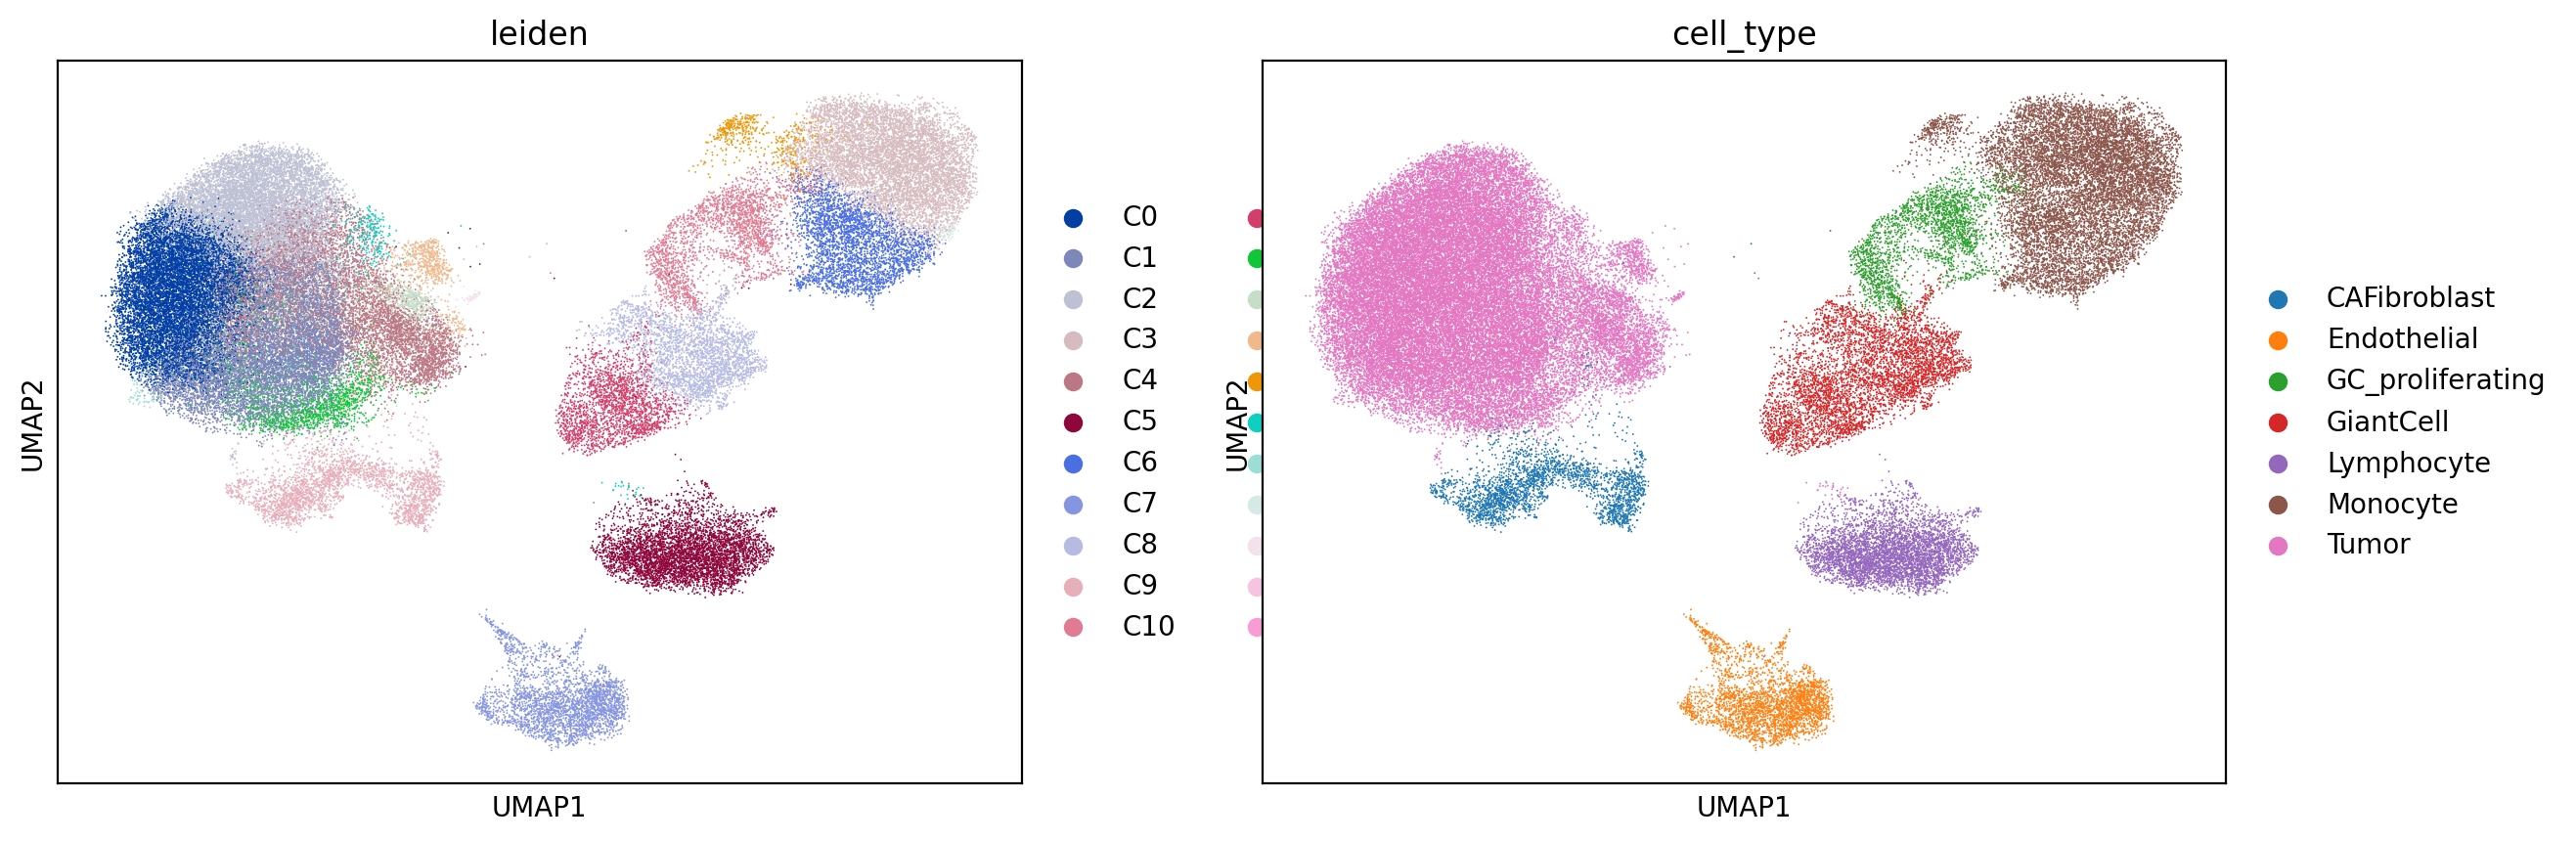

In [24]:
sc_adata_merged.obs['cell_type'] = [annotation_dict[clust] for clust in sc_adata_merged.obs['leiden']]
# Doublet以外の細胞だけ残す
filtered_sc_adata = sc_adata_merged[~sc_adata_merged.obs['cell_type'].isin(['Doublet', 'Other'])].copy()
sc.pl.umap(filtered_sc_adata, color=['leiden', 'cell_type'])
#filtered_sc_adata.obs['cell_type_annotation'] = filtered_sc_adata.obs['cell_type']
filtered_sc_adata.obs['cell_type_annotation'] = filtered_sc_adata.obs['leiden']
filtered_sc_adata.write_h5ad(h5ad_sc_filtered_full_save_path)

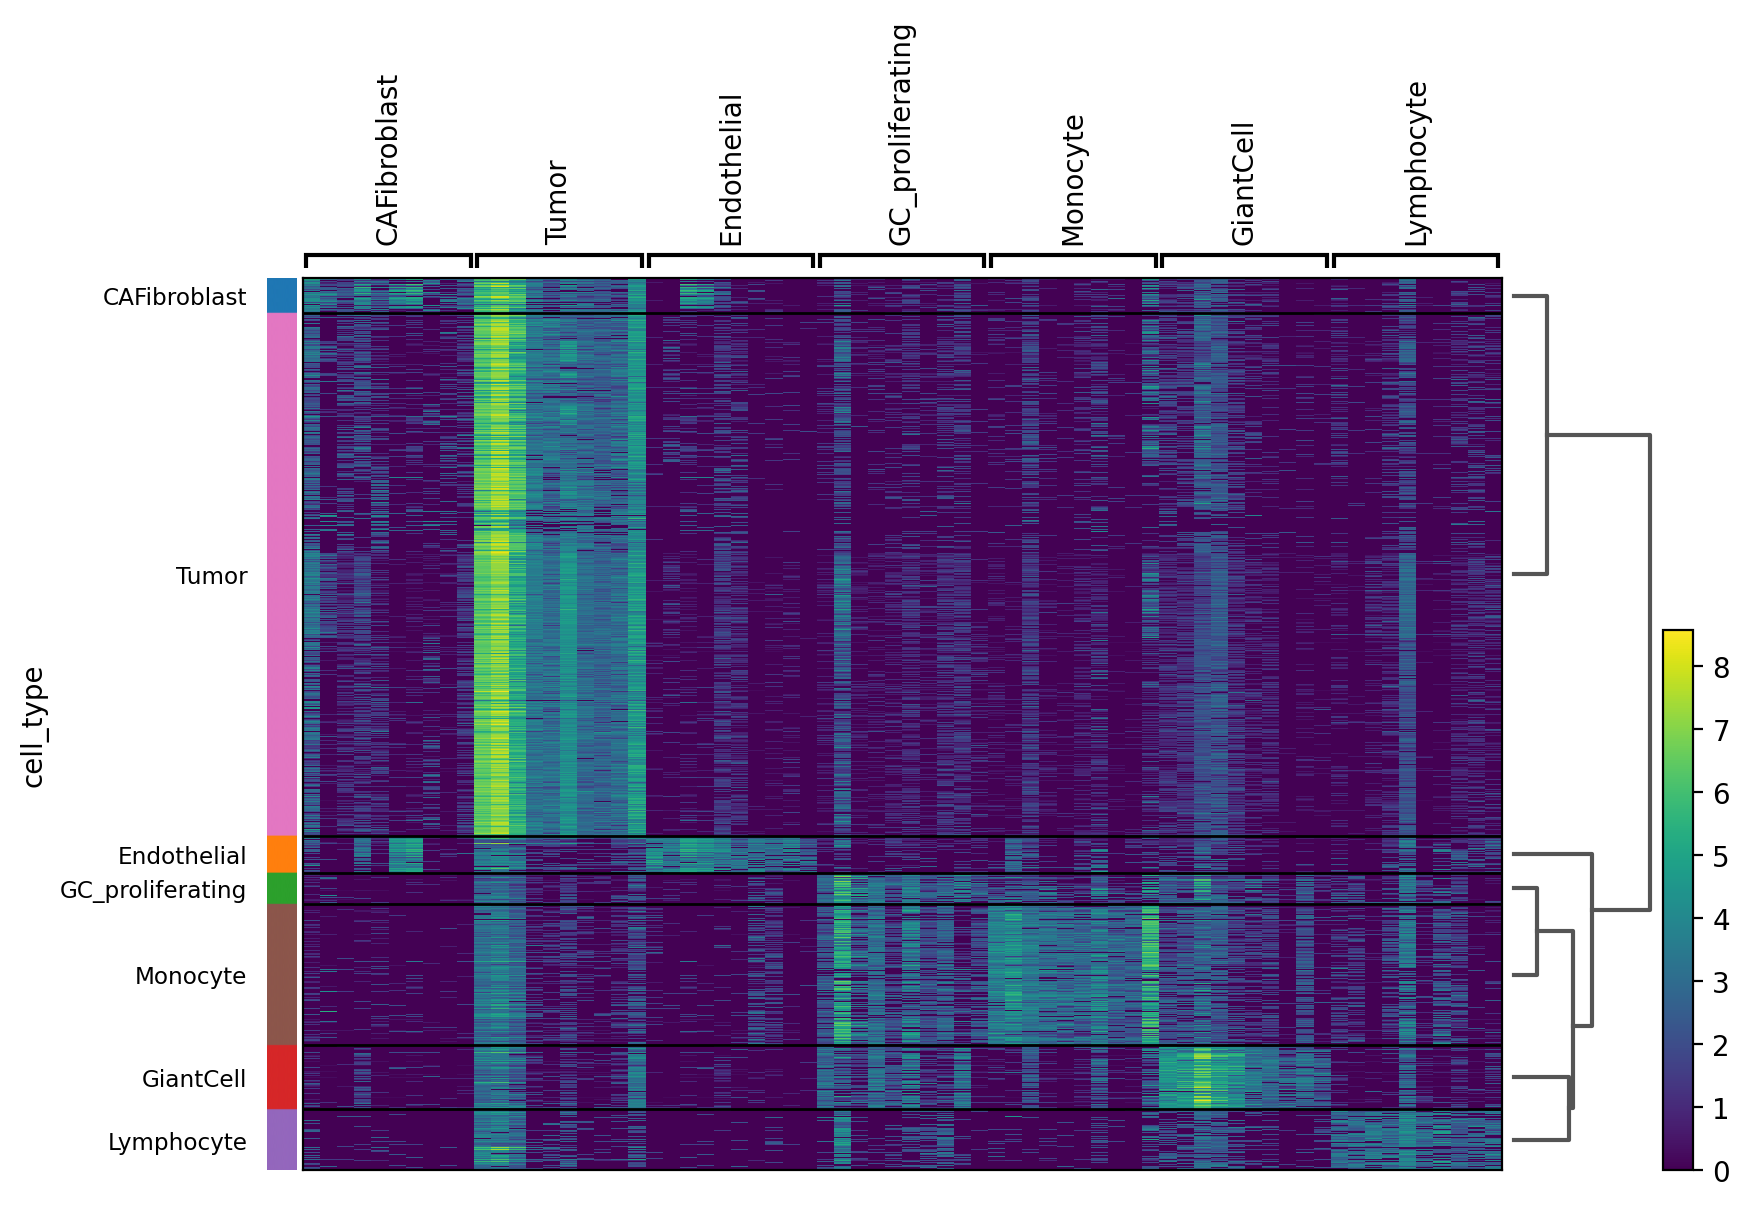

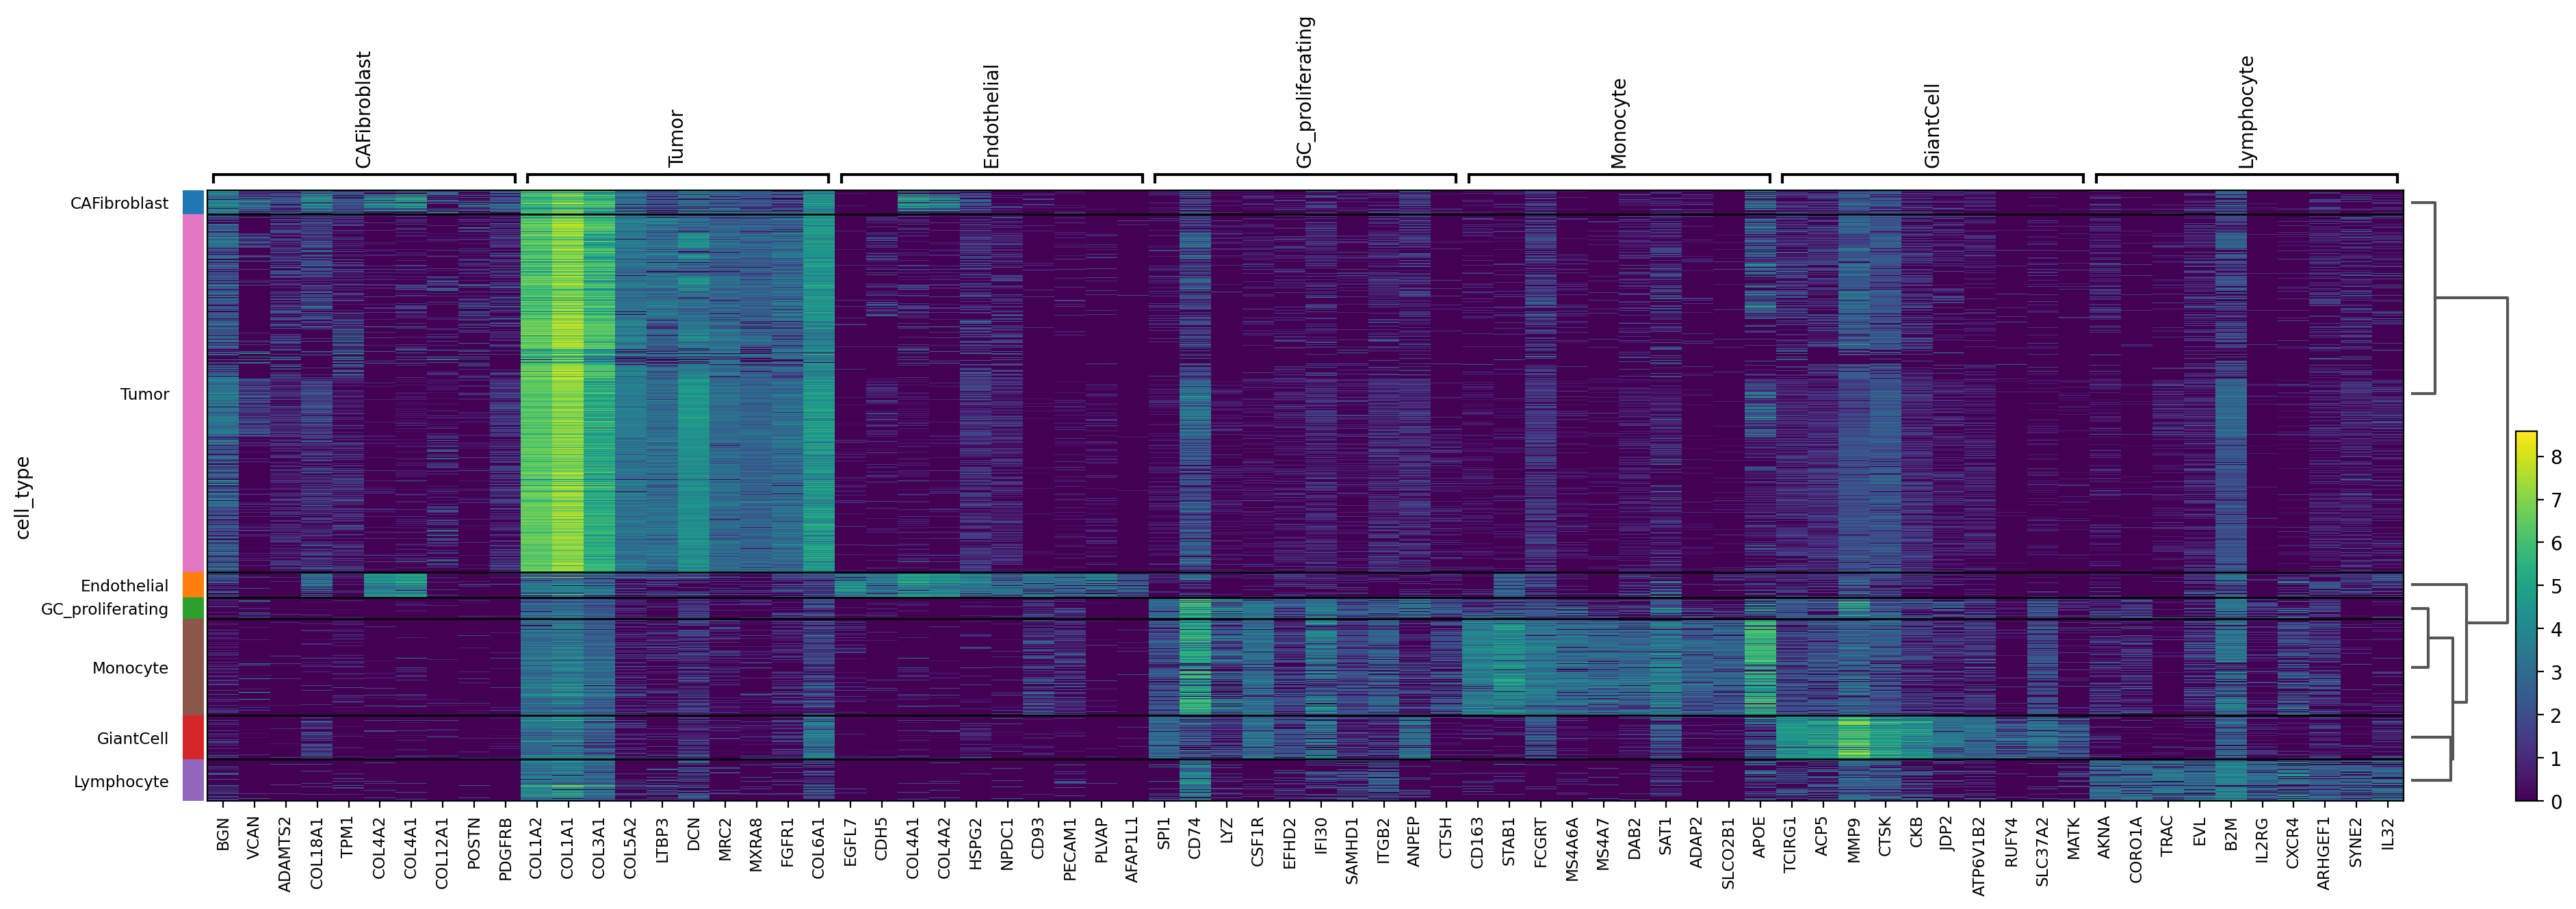

In [25]:
sc.tl.dendrogram(filtered_sc_adata, groupby='cell_type')
sc.tl.rank_genes_groups(filtered_sc_adata, 'cell_type', method='wilcoxon', use_raw=False)
sc.pl.rank_genes_groups_heatmap(filtered_sc_adata, use_raw=False)
sc.pl.rank_genes_groups_heatmap(filtered_sc_adata, show_gene_labels=True, use_raw=False)
